In [0]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-beta0
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

# Additional imports
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt

Saving kaggle.json to kaggle.json
     |████████████████████████████████| 348.9MB 74kB/s 
     |████████████████████████████████| 501kB 43.4MB/s 
     |████████████████████████████████| 3.1MB 44.6MB/s 


In [3]:
# Download and unzip data (2.1 GB)
datadir = Path.cwd() / 'data'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted')} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

 96% 250M/259M [00:02<00:00, 144MB/s]
100% 259M/259M [00:02<00:00, 128MB/s]
Finished downloading and extracting data.


In [0]:
!pip install h5py

In [0]:
def _recurse_get_dict_from_group(grp):
    result = dict(grp.attrs)
    for k, v in result.items():
        if isinstance(v, np.ndarray) and v.dtype.char == 'S':
            result[k] = v.astype('U').astype('O')
    for k, v in grp.items():
        result[k] = _recurse_get_dict_from_group(v)
    return result


def from_neuropype_h5(filename):
    import h5py
    from pandas import DataFrame
    f = h5py.File(filename, 'r')

    chunks = []
    if 'chunks' in f.keys():
        chunks_group = f['chunks']
        for ch_key in chunks_group.keys():
            chunk_group = chunks_group.get(ch_key)
            # Process data
            block_group = chunk_group.get('block')
            data_ = block_group.get('data')
            if isinstance(data_, h5py.Dataset):
                data = data_[()]
            else:
                # Data is a group. This only happens with sparse matrices.
                import scipy.sparse
                data = scipy.sparse.csr_matrix((data_['data'][:], data_['indices'][:], data_['indptr'][:]),
                                               data_.attrs['shape'])

            axes_group = block_group.get('axes')
            axes = []
            for ax_ix, axis_key in enumerate(axes_group.keys()):
                axis_group = axes_group.get(axis_key)
                ax_type = axis_group.attrs.get('type')
                new_ax = {'name': axis_key, 'type': ax_type}
                if ax_type == 'axis':
                    new_ax.update(dict(x=np.arange(data.shape[ax_ix])))
                elif ax_type == 'time':
                    nom_rate = axis_group.attrs.get('nominal_rate')
                    if np.isnan(nom_rate):
                        nom_rate = None
                    new_ax.update(dict(nominal_rate=nom_rate,
                                       times=axis_group.get('times')[()]))
                elif ax_type == 'frequency':
                    new_ax.update(dict(frequencies=axis_group.get('frequencies')[()]))
                elif ax_type == 'space':
                    new_ax.update(dict(names=axis_group.get('names')[()],
                                       naming_system=axis_group.attrs['naming_system'],
                                       positions=axis_group.get('positions')[()],
                                       coordinate_system=axis_group.attrs['coordinate_system'],
                                       units=axis_group.get('units')[()]))
                elif ax_type == 'feature':
                    new_ax.update(dict(names=axis_group.get('names')[()],
                                       units=axis_group.get('units')[()],
                                       properties=axis_group.get('properties')[()],
                                       error_distrib=axis_group.get('error_distrib')[()],
                                       sampling_distrib=axis_group.get('sampling_distrib')[()]))
                elif ax_type == 'instance':
                    new_ax.update({'times': axis_group.get('times')[()]})
                    if 'instance_type' in axis_group.attrs:
                        new_ax.update({'instance_type': axis_group.attrs['instance_type']})
                    _dat = axis_group.get('data')[()]
                    if not _dat.dtype.names:
                        new_ax.update({'data': axis_group.get('data')[()]})
                    else:
                        _df = DataFrame(_dat)
                        # Convert binary objects to string objects
                        str_df = _df.select_dtypes([np.object])
                        str_df = str_df.stack().str.decode('utf-8').unstack()
                        for col in str_df:
                            _df[col] = str_df[col]
                        new_ax.update({'data': _df})

                elif ax_type == 'statistic':
                    new_ax.update(dict(param_types=axis_group.get('param_types')[()]))
                elif ax_type == 'lag':
                    new_ax.update(dict(xlags=axis_group.get('lags')[()]))
                if new_ax is not None:
                    axes.append(new_ax)

            chunks.append((ch_key, dict(data=data, axes=axes,
                                        props=_recurse_get_dict_from_group(chunk_group.get('props')))))

    return chunks
  
def load_macaque_pfc(data_path, sess_id, x_chunk='spikerates', zscore=False):
    """
    Load a file from the KJM faces_basic dataset.
    :param data_path: Path object pointing to the root of the data directory (parent of 'converted/faces_basic')
    :param sess_id: Subject ID (2-character string)
    :param x_chunk: Type of data to return. Options are 'analogsignals' (i.e. LFPs), 'spikerates', 'spiketrains'
    :param zscore: Set True to center and standardize X data per-channel.
    :return: X, Y, ax_info
    """
    test_file = data_path / 'converted' / (sess_id + '_segmented.h5')
    chunks = from_neuropype_h5(test_file)
    chunk_names = [_[0] for _ in chunks]
    chunk = chunks[chunk_names.index(x_chunk)][1]
    ax_types = [_['type'] for _ in chunk['axes']]
    inst_ix, time_ix, space_ix = (ax_types.index(_) for _ in ('instance', 'time', 'space'))
    instance_axis = chunk['axes'][inst_ix]
    X = chunk['data']
    Y = instance_axis['data']['sacClass'].values.reshape(-1, 1)
    ax_info = {'instance_data': instance_axis['data'],
               'fs': chunk['axes'][time_ix]['nominal_rate'],
               'timestamps': chunk['axes'][time_ix]['times'],
               'channel_names': chunk['axes'][space_ix]['names'],
               'channel_locs': chunk['axes'][space_ix]['positions']
               }

    if time_ix > space_ix:
        # LFPs were stored with axes order reversed.
        X = np.transpose(X, (0, 2, 1))

    if zscore:
        if x_chunk == 'spiketrains':
            raise ValueError("Cannot z-score boolean spiketrains.")
        # Centre and standardize across all trials*samples
        tmp = np.reshape(X, (X.shape[0] * X.shape[1], X.shape[2]))
        X = (X - np.mean(tmp, axis=0)) / np.std(tmp, axis=0)

    return X, Y, ax_info
  

def pos_sigmoid(saccade):
    x = np.arange(-155., 155., 310/171)
    y = np.zeros((8, 171))
    y[-1] = -12 / (1+(1.3**(-x)))
    y[0] = -7 / (1+(1.03**(-x)))
    y[1] = 2 / (1+(1.03**(-x)))
    y[2] = 7 / (1 + (1.03 ** (-x)))
    y[3] = 12 / (1 + (1.3 ** (-x)))
    y[4] = 7 / (1 + (1.03 ** (x)))
    y[5] = 2 / (1 + (1.03 ** (x)))
    y[6] = -7 / (1 + (1.03 ** (x)))
    return y[saccade]

In [0]:
SESS_ID = ['sra3_1_j_050_00', 'sra3_1_m_074_0001']
BATCH_SIZE = 8
P_TRAIN = 0.8
BIN_DURATION = 25     # Width of window used to bin spikes, in 10 ms
BIN_OVRLP = 4
N_TAPS = 8            # Number of bins of history used in a sequence.
P_DROPOUT = 0.5      # Proportion of units to set to 0 on each step.
N_RNN_UNITS = 100      # Size of RNN output (state)
L2_REG = 1.7e-4       # Parameter regularization strength.
STATEFUL = False      # Whether or not to keep state between sequences (True is not tested)
EPOCHS = 15          # Number of loops through the entire data set.

In [6]:
# MONKEY J DATA

X2, y, ax_info = load_macaque_pfc(datadir, SESS_ID[0], zscore=True)

X = np.zeros((X2.shape[0], N_TAPS, X2.shape[2]))
Y = np.zeros((X2.shape[0], 8))
for j in range(N_TAPS-1):
  X[:, j, :] = np.mean(X2[:, j*(BIN_DURATION - BIN_OVRLP):j*(BIN_DURATION - BIN_OVRLP) + BIN_DURATION, :], axis=1)

X[:, N_TAPS-1, :] = np.mean(X2[:, (N_TAPS-1)*(BIN_DURATION - BIN_OVRLP):, :], axis=1)
for i in range(X2.shape[0]):
  Y[i, y[i]] = 1
  
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, train_size=P_TRAIN)

ds_train_j = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
ds_valid_j = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))

ds_train_j = ds_train_j.shuffle(int(X.shape[0] * P_TRAIN) + 1)
ds_train_j = ds_train_j.batch(BATCH_SIZE, drop_remainder=True)
ds_valid_j = ds_valid_j.batch(BATCH_SIZE, drop_remainder=True)

  
print(ds_train_j)

<BatchDataset shapes: ((8, 8, 32), (8, 8)), types: (tf.float64, tf.float64)>


In [7]:
# MONKEY M DATA

X2, y, ax_info = load_macaque_pfc(datadir, SESS_ID[1], zscore=True)

X = np.zeros((X2.shape[0], N_TAPS, X2.shape[2]))
Y = np.zeros((X2.shape[0], 8))
for j in range(N_TAPS-1):
  X[:, j, :] = np.mean(X2[:, j*(BIN_DURATION - BIN_OVRLP):j*(BIN_DURATION - BIN_OVRLP) + BIN_DURATION, :], axis=1)

X[:, N_TAPS-1, :] = np.mean(X2[:, (N_TAPS-1)*(BIN_DURATION - BIN_OVRLP):, :], axis=1)
for i in range(X2.shape[0]):
  Y[i, y[i]] = 1
  
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, train_size=P_TRAIN)

ds_train_m = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
ds_valid_m = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))

ds_train_m = ds_train_m.shuffle(int(X.shape[0] * P_TRAIN) + 1)
ds_train_m = ds_train_m.batch(BATCH_SIZE, drop_remainder=True)
ds_valid_m = ds_valid_m.batch(BATCH_SIZE, drop_remainder=True)

  
print(ds_train_m)

<BatchDataset shapes: ((8, 8, 32), (8, 8)), types: (tf.float64, tf.float64)>


In [0]:
input_shape = X.shape[1:]
output_shape = 8

inputs = tf.keras.layers.Input(shape = input_shape)
o1 = tf.keras.layers.LSTM(N_RNN_UNITS, dropout = P_DROPOUT,
                          recurrent_dropout = 0,
                          kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                          recurrent_regularizer=tf.keras.regularizers.l2(L2_REG),
                          return_sequences=False, stateful=False)(inputs)
o2 = tf.keras.layers.Dropout(P_DROPOUT)(o1)
# o3 = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_REG))(o2)
outputs = tf.keras.layers.Dense(output_shape, activation='softmax')(o2)

model_j = tf.keras.Model(inputs, outputs)
# adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_j.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_j.summary()

model_m = tf.keras.Model(inputs, outputs)
model_m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_m.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 8, 32)]           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 808       
Total params: 54,008
Trainable params: 54,008
Non-trainable params: 0
_________________________________________________________________
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 8, 32)]           0         
____________________________________

In [0]:
# MONKEY J MODEL FIT
history = model_j.fit(x=ds_train_j, epochs=EPOCHS, verbose=1, validation_data=ds_valid_j)

Epoch 1/15
76/76 [==============================] - 3s 38ms/step - loss: 1.5864 - accuracy: 0.4770 - val_loss: 0.9503 - val_accuracy: 0.6711
Epoch 2/15
76/76 [==============================] - 1s 16ms/step - loss: 0.8326 - accuracy: 0.6612 - val_loss: 0.6317 - val_accuracy: 0.6974
Epoch 3/15
76/76 [==============================] - 1s 16ms/step - loss: 0.6750 - accuracy: 0.7368 - val_loss: 0.5811 - val_accuracy: 0.7237
Epoch 4/15
76/76 [==============================] - 1s 16ms/step - loss: 0.6136 - accuracy: 0.7319 - val_loss: 0.5547 - val_accuracy: 0.7039
Epoch 5/15
76/76 [==============================] - 1s 16ms/step - loss: 0.5623 - accuracy: 0.7681 - val_loss: 0.5339 - val_accuracy: 0.7434
Epoch 6/15
76/76 [==============================] - 1s 16ms/step - loss: 0.5304 - accuracy: 0.7697 - val_loss: 0.5073 - val_accuracy: 0.7763
Epoch 7/15
76/76 [==============================] - 1s 16ms/step - loss: 0.5045 - accuracy: 0.7944 - val_loss: 0.4892 - val_accuracy: 0.8026
Epoch 8/15
76

In [0]:
# MONKEY M MODEL FIT
history = model_m.fit(x=ds_train_m, epochs=EPOCHS, verbose=1, validation_data=ds_valid_m)

Epoch 1/15
88/88 [==============================] - 3s 39ms/step - loss: 1.6632 - accuracy: 0.3821 - val_loss: 1.1754 - val_accuracy: 0.5455
Epoch 2/15
88/88 [==============================] - 1s 15ms/step - loss: 1.1367 - accuracy: 0.5440 - val_loss: 0.9560 - val_accuracy: 0.6193
Epoch 3/15
88/88 [==============================] - 1s 15ms/step - loss: 1.0136 - accuracy: 0.5739 - val_loss: 0.8614 - val_accuracy: 0.6591
Epoch 4/15
88/88 [==============================] - 1s 15ms/step - loss: 0.9237 - accuracy: 0.6094 - val_loss: 0.8144 - val_accuracy: 0.6705
Epoch 5/15
88/88 [==============================] - 1s 15ms/step - loss: 0.8843 - accuracy: 0.6449 - val_loss: 0.7753 - val_accuracy: 0.7159
Epoch 6/15
88/88 [==============================] - 1s 15ms/step - loss: 0.8208 - accuracy: 0.6903 - val_loss: 0.7807 - val_accuracy: 0.6648
Epoch 7/15
88/88 [==============================] - 1s 15ms/step - loss: 0.7999 - accuracy: 0.6648 - val_loss: 0.7512 - val_accuracy: 0.7216
Epoch 8/15
88

In [0]:
pred_y = model.predict(x=X)

[(32, 400), (100, 400), (400,)]


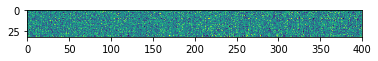

In [0]:
print([_.shape for _ in model.layers[1].get_weights()])

plt.imshow(model.layers[1].get_weights()[0])

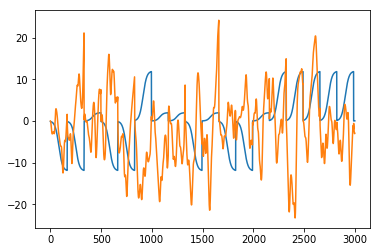

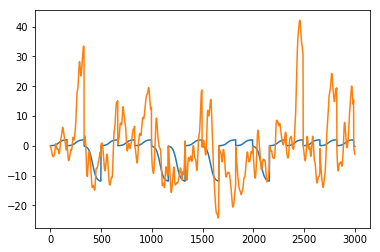

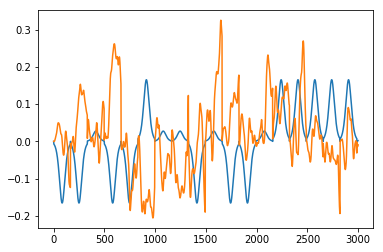

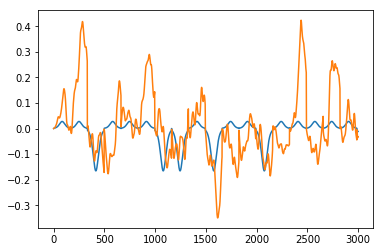

In [34]:
**KALMAN FILTER**